# Michael Kasman - ASE 389 (L4DC)
# Homework 1 Part 3 - Learning Nonlinear Dynamical Systems using Gaussian Processes
## Nonlinear Mass-Spring Damper System

<img src="images/mass_spring_damper.png" width=250 height=250/>
<img src="images/equations.png" width=250 height=250/>
<img src="images/state_space.png" width=250 height=250/>

In [19]:
# import libraries
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [20]:
# Function that returns dx/dt
def mydiff(x, t): 
    c = 10 # Damping constant
    k = 10 # Stiffness of the spring
    m = 50 # Mass
    F = 10 # Force
    dx1dt = x[1] 
    dx2dt = (F - c*x[1] - k*x[0])/m
    dxdt = [dx1dt, dx2dt]
    
    return dxdt

In [21]:
# posterior
# Initial condition
x_init = [0,0]
t_post = np.linspace(0, 40, num=75)

# Solve ODE
x = odeint(mydiff, x_init, t_post)

# x1 - position
x1_post = x[:,0]

# x2 - velocity/speed
x2_post = x[:,1]

In [22]:
# extract first 30 seconds of position and reshape into 2D array
posterior_pos = x1_post
posterior_pos = np.reshape(posterior_pos, (-1, 1))

In [23]:
# Initialization
tstart = 0
tstop = 60
increment = 1

# Initial condition
x_init = [0,0]
t = np.arange(tstart,tstop+1,increment)

# Solve ODE
x = odeint(mydiff, x_init, t)

# x1 - position
x1 = x[:,0]

# x2 - velocity/speed
x2 = x[:,1]

In [24]:
# extract seconds 5 to 35 of position and reshape into 2D array
position = x[5:35, 0]
position = np.reshape(position, (-1, 1))

In [25]:
time = t[5:35].reshape(-1,1)
time_df = pd.DataFrame(time)
init_df = pd.DataFrame(np.zeros((30, 2)))

x1_df = pd.concat([time_df, init_df], axis=1)
samp_time = x1_df.to_numpy()

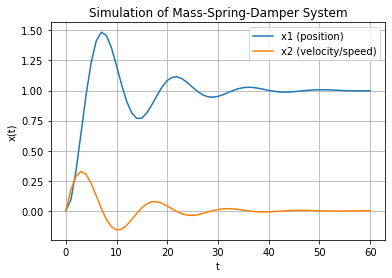

In [26]:
# Plot the Results
plt.plot(t,x1)
plt.plot(t,x2)
plt.title('Simulation of Mass-Spring-Damper System')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend(["x1 (position)", "x2 (velocity/speed)"])
plt.grid()
plt.show()

## Apply Gaussian Process Regression
### Visualization 1 (Training set from when t = 5 to 35)

In [27]:
import scipy
from scipy.spatial import distance
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm # colormap

In [28]:
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [29]:
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    S11 = kernel_func(X1, X1) # in our case the Kernel will be the exponential quadratic Kernel
    # Kernel of observations vs to-predict
    S12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(S11, S12, assume_a='pos').T # this solves for {\Sigma_11)^{-1} \Sigma_12 which appers both in the posterior's mean and covariance
    # Compute posterior mean
    mu2 = solved @ y1
    # Compute the posterior covariance
    S22 = kernel_func(X2, X2)
    S2 = S22 - (solved @ S12)
    return mu2, S2  # mean, covariance

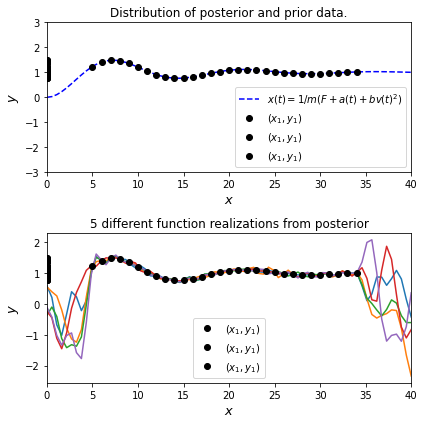

In [30]:
n1 = 8  # Number of points to condition on (training points). These are the points where we have measurements y = f(x)
n2 = 75  # Number of points in posterior (test points). These are the points where we want to predict without having measurements
ny = 5  # Number of functions that will be sampled from the posterior. These are the various realizations of the GP posterior.
domain = (0, 40) # This is the input domain

# Sample observations (X1, y1) on the function
# sample time
X1 = samp_time

# position
y1 = position

# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1) # here we use 75 points in the domain X = (0,40) to predict process
X2 = np.concatenate((X2, np.zeros((n2,2))), axis=1)

# Compute posterior mean and covariance
mu2, S2 = GP(X1, y1, X2, exponentiated_quadratic) # here is where the posterior is calcuate 
# Compute the standard deviation at the test points to be plotted
ss2 = np.sqrt(np.diag(S2))

# Draw some samples of the posterior
mu2 = mu2.flatten()
y2 = np.random.multivariate_normal(mean=mu2, cov=S2, size=ny) # we draw ny realizations of the posterior Gaussian Process

# plot posterior distribution
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

# Let's first plot the process and the mean of the 5 realizatons

# Plot the distribution of the function (mean, covariance)
ax1.plot(X2[:,0], posterior_pos, 'b--', label='$x(t) = 1/m(F + a(t) + b v(t)^2)$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2[:,0], y2.T, '-')
ax2.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax2.set_xlim([0, 40])
ax2.legend()

plt.tight_layout()
plt.show()

### Superimpose the prediction and the actual process plus the confidence bounds equal to $\pm 2\,\sigma_2$

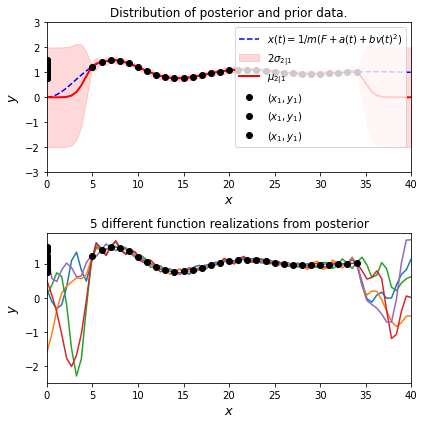

In [31]:
n1 = 8  # Number of points to condition on (training points). These are the points where we have measurements y = f(x)
n2 = 75  # Number of points in posterior (test points). These are the points where we want to predict without having measurements
ny = 5  # Number of functions that will be sampled from the posterior. These are the various realizations of the GP posterior.
domain = (0, 40) # This is the input process

# Sample observations (X1, y1) on the function
X1 = samp_time
y1 = position

# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1) # here we use 75 points in the domain X = (0,40) to predict process
X2 = np.concatenate((X2, np.zeros((n2,2))), axis=1)

# Compute posterior mean and covariance
mu2, S2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
ss2 = np.sqrt(np.diag(S2))

# Draw some samples of the posterior
mu2 = mu2.flatten()
y2 = np.random.multivariate_normal(mean=mu2, cov=S2, size=ny) # we draw ny realizations of the posterior Gaussian Process

# plot posterior distribution
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

# Plot the distribution of the function (mean, covariance)
ax1.plot(X2[:,0], posterior_pos, 'b--', label='$x(t) = 1/m(F + a(t) + b v(t)^2)$')
ax1.fill_between(X2[:,0].flat, mu2-2*ss2, mu2+2*ss2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$') # here we are filling the subplot 1 (referenced with ax1 axes pointer) with color between mu2±sigma2
ax1.plot(X2[:,0], mu2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2[:,0], y2.T, '-')
ax2.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([0, 40])
plt.tight_layout()
plt.show()

### Visualization 2 (Training set from when t = 15 to 30)

In [32]:
# extract seconds 15 to 30 of position and reshape into 2D array
position = x[15:30, 0]
position = np.reshape(position, (-1, 1))

In [33]:
time = t[15:30].reshape(-1,1)
time_df = pd.DataFrame(time)
init_df = pd.DataFrame(np.zeros((15, 2)))

x1_df = pd.concat([time_df, init_df], axis=1)
samp_time = x1_df.to_numpy()

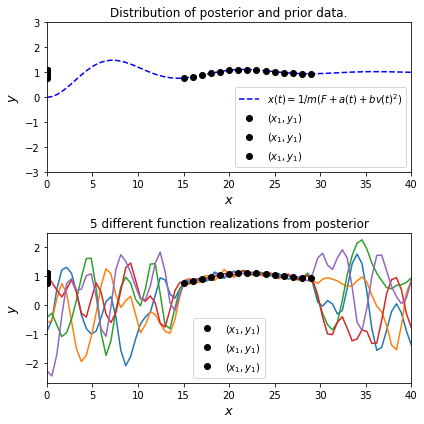

In [34]:
n1 = 8  # Number of points to condition on (training points). These are the points where we have measurements y = f(x)
n2 = 75  # Number of points in posterior (test points). These are the points where we want to predict without having measurements
ny = 5  # Number of functions that will be sampled from the posterior. These are the various realizations of the GP posterior.
domain = (0, 40) # This is the input domain

# Sample observations (X1, y1) on the function
# sample time
X1 = samp_time

# position
y1 = position

# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1) # here we use 75 points in the domain X = (0,40) to predict process
X2 = np.concatenate((X2, np.zeros((n2,2))), axis=1)

# Compute posterior mean and covariance
mu2, S2 = GP(X1, y1, X2, exponentiated_quadratic) # here is where the posterior is calcuate 
# Compute the standard deviation at the test points to be plotted
ss2 = np.sqrt(np.diag(S2))

# Draw some samples of the posterior
mu2 = mu2.flatten()
y2 = np.random.multivariate_normal(mean=mu2, cov=S2, size=ny) # we draw ny realizations of the posterior Gaussian Process

# plot posterior distribution
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

# Let's first plot the process and the mean of the 5 realizatons

# Plot the distribution of the function (mean, covariance)
ax1.plot(X2[:,0], posterior_pos, 'b--', label='$x(t) = 1/m(F + a(t) + b v(t)^2)$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2[:,0], y2.T, '-')
ax2.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax2.set_xlim([0, 40])
ax2.legend()

plt.tight_layout()
plt.show()

### Superimpose the prediction and the actual process plus the confidence bounds equal to $\pm 2\,\sigma_2$

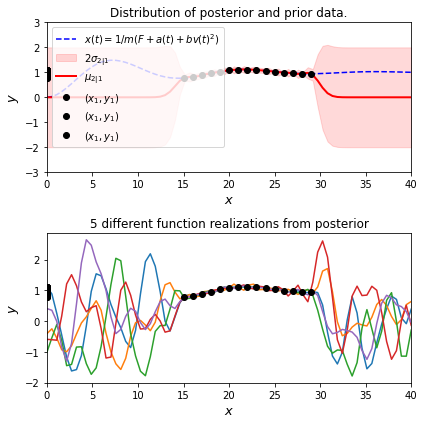

In [35]:
n1 = 8  # Number of points to condition on (training points). These are the points where we have measurements y = f(x)
n2 = 75  # Number of points in posterior (test points). These are the points where we want to predict without having measurements
ny = 5  # Number of functions that will be sampled from the posterior. These are the various realizations of the GP posterior.
domain = (0, 40) # This is the input process

# Sample observations (X1, y1) on the function
X1 = samp_time
y1 = position

# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1) # here we use 75 points in the domain X = (0,40) to predict process
X2 = np.concatenate((X2, np.zeros((n2,2))), axis=1)

# Compute posterior mean and covariance
mu2, S2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
ss2 = np.sqrt(np.diag(S2))

# Draw some samples of the posterior
mu2 = mu2.flatten()
y2 = np.random.multivariate_normal(mean=mu2, cov=S2, size=ny) # we draw ny realizations of the posterior Gaussian Process

# plot posterior distribution
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

# Plot the distribution of the function (mean, covariance)
ax1.plot(X2[:,0], posterior_pos, 'b--', label='$x(t) = 1/m(F + a(t) + b v(t)^2)$')
ax1.fill_between(X2[:,0].flat, mu2-2*ss2, mu2+2*ss2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$') # here we are filling the subplot 1 (referenced with ax1 axes pointer) with color between mu2±sigma2
ax1.plot(X2[:,0], mu2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2[:,0], y2.T, '-')
ax2.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([0, 40])
plt.tight_layout()
plt.show()